<a href="https://colab.research.google.com/github/AtSourav/L2-vs-L1-vs-CB-loss-in-deep-CNN-based-AE-on-cifar10/blob/main/AE_cifar10_mse_HeNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [ ]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 200
batch_size = 128

initializer = initializers.HeNormal(seed=100)

# **Loading the dataset**

In [ ]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL145QW/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL145QW/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

In [ ]:
img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

# **Defining the model**

In [ ]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 30, 30, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        16448     
                                                                 
 re_lu_1 (ReLU)              (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                           

In [ ]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = layers.Conv2DTranspose(1024, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

x = layers.Conv2D(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_10 (Dense)            (None, 400)               80400     
                                                                 
 re_lu_66 (ReLU)             (None, 400)               0         
                                                                 
 dense_11 (Dense)            (None, 600)               240600    
                                                                 
 re_lu_67 (ReLU)             (None, 600)               0         
                                                                 
 dense_12 (Dense)            (None, 800)               480800    
                                                                 
 re_lu_68 (ReLU)             (None, 800)               0   

In [ ]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 200)               6943472   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         9199307   
                                                                 
Total params: 16142779 (61.58 MB)
Trainable params: 16142779 (61.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
K.clear_session()

# **Training**

In [ ]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=2000, decay_rate=0.7)
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75, steps_per_epoch=None)

Epoch 1/75
391/391 [==============================] - 37s 63ms/step - loss: 0.0338 - val_loss: 0.0225
Epoch 2/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0192 - val_loss: 0.0167
Epoch 3/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 4/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 5/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 6/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 7/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 8/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 9/75
391/391 [==============================] - 22s 56ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 10/75
391/391 [==============================] - 22s 56ms/step - loss: 0.011

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.000005)
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=25, callbacks = [callback], steps_per_epoch=None)

Epoch 1/25
391/391 [==============================] - 34s 60ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 2/25
391/391 [==============================] - 22s 56ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 3/25
391/391 [==============================] - 22s 57ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 4/25
391/391 [==============================] - 22s 56ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 5/25
391/391 [==============================] - 22s 56ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 6/25
391/391 [==============================] - 22s 56ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 7/25
391/391 [==============================] - 22s 57ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 8/25
391/391 [==============================] - 22s 57ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 9/25
391/391 [==============================] - 22s 57ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 10/25
391/391 [==============================] - 22s 57ms/step - loss: 0.006

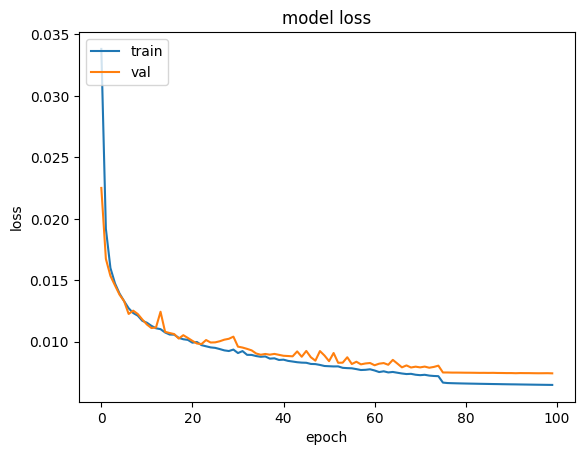

In [ ]:
plt.plot(history.history['loss']+history2.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Plotting some reconstructed images alongwith the originals**

In [ ]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

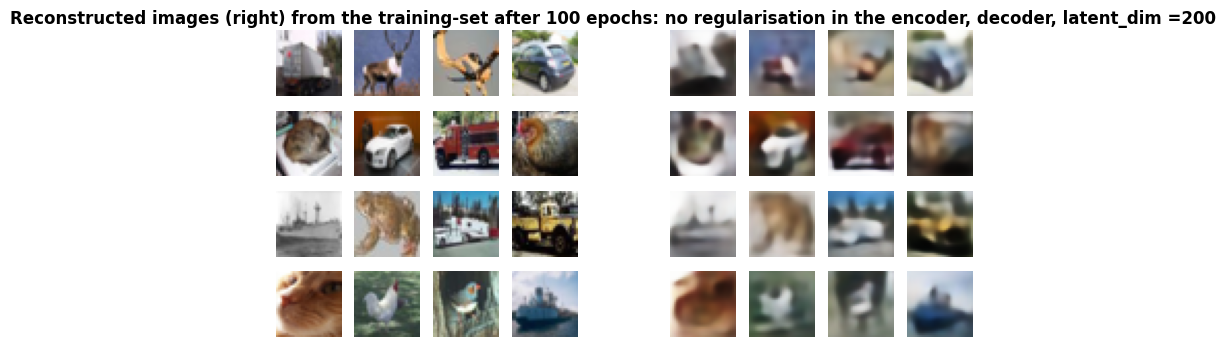

In [ ]:
plot_reconstruction(img_train, 'training',123,100)

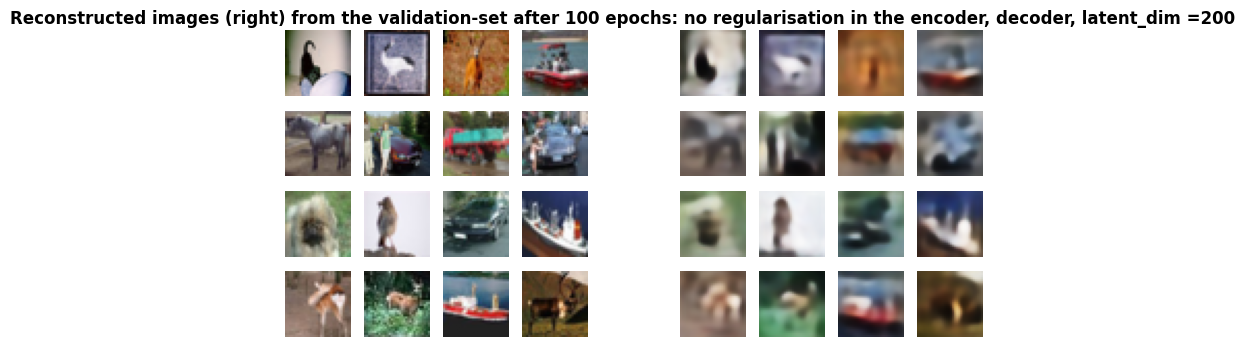

In [ ]:
plot_reconstruction(img_valid,'validation',123,100)